In [32]:
import torch
import os
import numpy as np

from Hamiltonian import Hamiltonian
from Ising import Ising
from model import TransformerModel
from model_utils import sample

## Hardware Setup

In [33]:
def gpu_setup():
    # Setup for PyTorch:
    if torch.cuda.is_available():
        torch_device = torch.device("cuda")
        print("PyTorch is using GPU {}".format(torch.cuda.current_device()))
    else:
        torch_device = torch.device("cpu")
        print("GPU unavailable; using CPU")

In [34]:
gpu_setup()
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

PyTorch is using GPU 0


## Model Setup

In [35]:
system_sizes = torch.arange(15, 15 + 2, 2).reshape(-1, 1)
Hamiltonians = [Ising(size, periodic=True, get_basis=False) for size in system_sizes]
param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 10000
param_range = None
point_of_interest = None
use_SR = False

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [36]:
model = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

model.cuda()

results_dir = "results"
paper_checkpoint_name = "ckpt_100000_Ising_32_8_8_0.ckpt"
paper_checkpoint_path = os.path.join(results_dir, paper_checkpoint_name)
checkpoint = torch.load(paper_checkpoint_path)
model.load_state_dict(checkpoint)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [37]:
def extract_energy_estimate(
    model,
    H: Hamiltonian,
    param: torch.Tensor,
    num_samples: int = 1000000,
    max_unique: int = 100,
):
    """
    Extracts an energy estimate from the model using the Hamiltonian H.
    Parameters:
        H: Hamiltonian
            The Hamiltonian object to use to produce the energy estimate
        param: torch.Tensor
            The parameters to obtain the energy estimate for
        num_samples: int
            The number of samples from the wave function the model represents to use
            in energy estimation
        max_unique: int
            The maximum number of unique samples to generate (see sample in model_utils.py)
    """
    model.set_param(system_size=H.system_size, param=param)
    symmetry = H.symmetry
    samples, sample_weight = sample(model, num_samples, max_unique, symmetry)
    E = H.Eloc(samples, sample_weight, model, use_symmetry=True)
    E_mean = (E * sample_weight).sum()
    E_var = (
        (((E - E_mean).abs() ** 2 * sample_weight).sum() / H.n**2)
        .detach()
        .cpu()
        .numpy()
    )
    Er = (E_mean.real / H.n).detach().cpu().numpy()
    Ei = (E_mean.imag / H.n).detach().cpu().numpy()

    return E_mean, E_var, Er, Ei

In [38]:
drmg40path = os.path.join("results", "E_dmrg_40.npy")
dmrg40 = np.load(drmg40path)
dmrg40 = torch.tensor(dmrg40, dtype=torch.float32)

ising40 = Ising(
    torch.tensor([40]),
    periodic=False,
    get_basis=False,
)

dmrg40_h_values = torch.linspace(0, 2, 101)
oneidx = torch.where(dmrg40_h_values == 1.0)[0][0]

In [39]:
dmrg40_h_values

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000, 1.0200, 1.0400, 1.0600,
        1.0800, 1.1000, 1.1200, 1.1400, 1.1600, 1.1800, 1.2000, 1.2200, 1.2400,
        1.2600, 1.2800, 1.3000, 1.3200, 1.3400, 1.3600, 1.3800, 1.4000, 1.4200,
        1.4400, 1.4600, 1.4800, 1.5000, 1.5200, 1.5400, 1.5600, 1.5800, 1.6000,
        1.6200, 1.6400, 1.6600, 1.6800, 1.7000, 1.7200, 1.7400, 1.7600, 1.7800,
        1.8000, 1.8200, 1.8400, 1.8600, 1.8800, 1.9000, 1.9200, 1.9400, 1.9600,
        1.9800, 2.0000], device='cuda:0')

In [40]:
dmrg40

tensor([-39.0000, -39.0042, -39.0168, -39.0378, -39.0672, -39.1051, -39.1513,
        -39.2061, -39.2693, -39.3409, -39.4211, -39.5098, -39.6071, -39.7130,
        -39.8275, -39.9507, -40.0826, -40.2233, -40.3728, -40.5311, -40.6984,
        -40.8747, -41.0600, -41.2545, -41.4581, -41.6711, -41.8935, -42.1253,
        -42.3668, -42.6180, -42.8790, -43.1500, -43.4311, -43.7225, -44.0244,
        -44.3369, -44.6603, -44.9948, -45.3407, -45.6982, -46.0677, -46.4496,
        -46.8443, -47.2526, -47.6751, -48.1128, -48.5672, -49.0395, -49.5307,
        -50.0410, -50.5694, -51.1143, -51.6740, -52.2469, -52.8316, -53.4271,
        -54.0323, -54.6465, -55.2689, -55.8988, -56.5359, -57.1794, -57.8291,
        -58.4846, -59.1454, -59.8112, -60.4818, -61.1569, -61.8363, -62.5196,
        -63.2067, -63.8975, -64.5916, -65.2890, -65.9896, -66.6930, -67.3993,
        -68.1083, -68.8199, -69.5339, -70.2502, -70.9688, -71.6896, -72.4125,
        -73.1373, -73.8641, -74.5926, -75.3230, -76.0550, -76.78

In [41]:
predicted_energies = torch.zeros_like(params)

In [68]:
num_readings = 10
predicted_energies = torch.zeros(params.shape[0], num_readings)

In [80]:
for j in range(num_readings):
    for i, param in enumerate(dmrg40_h_values):
        param_tens = torch.tensor([param], dtype=torch.float32)
        E_mean, E_var, Er, Ei = extract_energy_estimate(model, ising40, param_tens)
        predicted_energies[i, j] = E_mean
        print(f"Predicted energy for h = {param}: {E_mean}")
    

Predicted energy for h = 0.0: (-38.14846420288086+0j)
Predicted energy for h = 0.019999999552965164: (-38.08270263671875+0.0021704435348510742j)
Predicted energy for h = 0.03999999910593033: (-38.38965606689453+0.004659133963286877j)
Predicted energy for h = 0.05999999865889549: (-38.80231475830078+0.00796753354370594j)
Predicted energy for h = 0.07999999821186066: (-38.62077713012695+0.010520651005208492j)
Predicted energy for h = 0.09999999403953552: (-36.25537109375-0.006111367605626583j)
Predicted energy for h = 0.11999999731779099: (-33.817161560058594-0.0431024432182312j)
Predicted energy for h = 0.14000000059604645: (-39.279483795166016+0.017926985397934914j)
Predicted energy for h = 0.1599999964237213: (-39.231475830078125+0.018870560452342033j)
Predicted energy for h = 0.17999999225139618: (-37.25539779663086-0.06711233407258987j)
Predicted energy for h = 0.19999998807907104: (-39.544776916503906+0.023647019639611244j)
Predicted energy for h = 0.2199999988079071: (-39.81098937

In [71]:
avg_predicted_energies = predicted_energies.mean(dim=1)

In [72]:
avg_predicted_energies

tensor([-37.3040, -36.0785, -38.2796, -36.1285, -35.7498, -37.5002, -37.8890,
        -37.7177, -37.8665, -38.1461, -38.7602, -38.6218, -39.1340, -39.1827,
        -39.3931, -38.9819, -39.6842, -40.2009, -40.0661, -40.1167, -40.5035,
        -40.7657, -41.0403, -41.2335, -41.4324, -41.6555, -41.8866, -42.1009,
        -42.3702, -42.6122, -42.8618, -43.1399, -43.3982, -43.7361, -44.0280,
        -44.3410, -44.6577, -45.0014, -45.3561, -45.6948, -46.0735, -46.4566,
        -46.8344, -47.2407, -47.6500, -48.1183, -48.5615, -49.0280, -49.5262,
        -50.0349, -50.5793, -51.1187, -51.6683, -52.2512, -52.8299, -53.4279,
        -54.0330, -54.6449, -55.2662, -55.9026, -56.5289, -57.1811, -57.8311,
        -58.4862, -59.1445, -59.8097, -60.4779, -61.1581, -61.8394, -62.5174,
        -63.2078, -63.8975, -64.5924, -65.2915, -65.9914, -66.6950, -67.3968,
        -68.1088, -68.8187, -69.5371, -70.2423, -70.9711, -71.6899, -72.4127,
        -73.1322, -73.8570, -74.5945, -75.3187, -76.0399, -76.77

In [55]:
predicted_energies.view(-1)

tensor([-31.2777, -38.3316, -38.4936, -29.2430, -38.7878, -39.0484, -39.1407,
        -36.7252, -37.0432, -37.4319, -39.4822, -37.8050, -39.9055, -38.4385,
        -40.0432, -38.9953, -38.2128, -39.2376, -40.6780, -40.7431, -40.9143,
        -40.2430, -40.8104, -41.1807, -41.4976, -41.6942, -41.9070, -42.1304,
        -42.3731, -42.6110, -42.8805, -43.1466, -43.5266, -43.7343, -44.0236,
        -44.3403, -44.6411, -45.0018, -45.3399, -45.6874, -46.1181, -46.4286,
        -46.8152, -47.2371, -47.7002, -48.0934, -48.5679, -49.0594, -49.5388,
        -50.0199, -50.5236, -51.1247, -51.6539, -52.2517, -52.8186, -53.4182,
        -54.0286, -54.6310, -55.2711, -55.8984, -56.5430, -57.1886, -57.8285,
        -58.4884, -59.1253, -59.8048, -60.4810, -61.1326, -61.8424, -62.5044,
        -63.2073, -63.8967, -64.6037, -65.2926, -65.9853, -66.6765, -67.4067,
        -68.1195, -68.8083, -69.5389, -70.2399, -70.9646, -71.7012, -72.3968,
        -73.1390, -73.8696, -74.5741, -75.3182, -76.0058, -76.79

In [73]:
relative_error = torch.abs((avg_predicted_energies.view(-1) - dmrg40) / dmrg40)

In [74]:
relative_error

tensor([4.3488e-02, 7.5011e-02, 1.8895e-02, 7.4525e-02, 8.4915e-02, 4.1039e-02,
        3.2243e-02, 3.7962e-02, 3.5722e-02, 3.0370e-02, 1.6766e-02, 2.2476e-02,
        1.1945e-02, 1.3352e-02, 1.0907e-02, 2.4251e-02, 9.9399e-03, 5.5623e-04,
        7.5950e-03, 1.0225e-02, 4.7886e-03, 2.6667e-03, 4.7856e-04, 5.0876e-04,
        6.2127e-04, 3.7551e-04, 1.6436e-04, 5.8028e-04, 7.9595e-05, 1.3516e-04,
        4.0176e-04, 2.3480e-04, 7.5765e-04, 3.1086e-04, 8.0757e-05, 9.2750e-05,
        5.8510e-05, 1.4693e-04, 3.4032e-04, 7.4878e-05, 1.2570e-04, 1.5021e-04,
        2.1213e-04, 2.5204e-04, 5.2554e-04, 1.1322e-04, 1.1727e-04, 2.3453e-04,
        9.0880e-05, 1.2212e-04, 1.9455e-04, 8.5228e-05, 1.1073e-04, 8.2505e-05,
        3.3503e-05, 1.4780e-05, 1.2779e-05, 2.8411e-05, 4.8936e-05, 6.7151e-05,
        1.2220e-04, 2.8687e-05, 3.3972e-05, 2.8178e-05, 1.4125e-05, 2.5065e-05,
        6.5090e-05, 1.9274e-05, 5.0154e-05, 3.5389e-05, 1.7623e-05, 8.9550e-07,
        1.2166e-05, 3.7511e-05, 2.7054e-

In [75]:
relative_error.max()

tensor(0.0849, device='cuda:0')

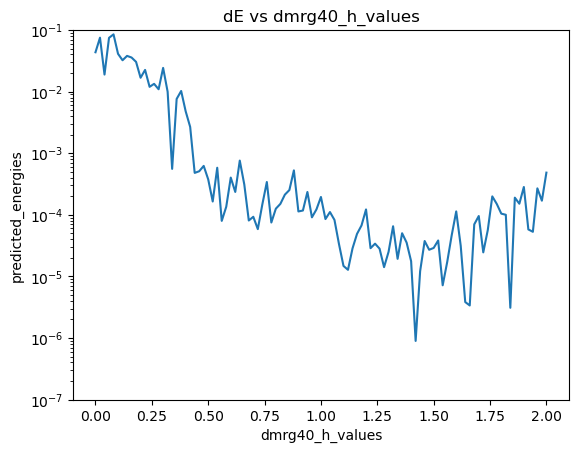

In [79]:
import matplotlib.pyplot as plt

plt.plot(dmrg40_h_values.cpu(), relative_error.cpu())
plt.xlabel('dmrg40_h_values')
plt.ylabel('predicted_energies')
plt.title('dE vs dmrg40_h_values')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylim(1e-7, 1e-1)  # Set y-axis range
plt.show()